## Load data

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_airlines = "./datasets/airlines.csv"
path_airport = "./datasets/airports.csv"
path_flights = "./datasets/flights.csv"

df_airlines = pd.read_csv(path_airlines, low_memory=False)
df_airport = pd.read_csv(path_airport, low_memory=False)
raw_flights = pd.read_csv(path_flights, low_memory=False)

In [3]:
df_flights = raw_flights.copy()
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

The flights data are collected in 2015, we visualize the flight frequency gouuped according to each month, we find that they are evenly distributed. 

<Axes: xlabel='YEAR,MONTH'>

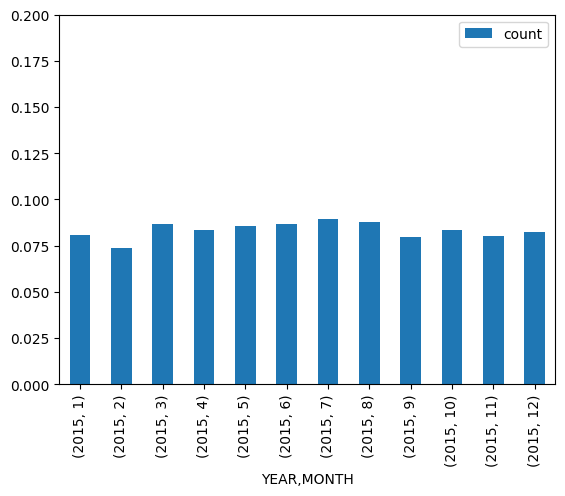

In [4]:
(df_flights.groupby([df_flights['YEAR'], df_flights['MONTH']]).agg({'count'})['FLIGHT_NUMBER']/df_flights['FLIGHT_NUMBER'].count()).plot(ylim=(0,0.2),kind="bar")


In [5]:
# transform df_airlines to dict
dict_airlines = df_airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

# only keep flight starting and ending from airport in the airports.csv
df_flights = df_flights[(df_flights['ORIGIN_AIRPORT'].isin(df_airport['IATA_CODE'])) & (df_flights['DESTINATION_AIRPORT'].isin(df_airport['IATA_CODE']))]

We change the format of "HHMM" string to minutes. 

In [6]:
def mintues(formatted_time):
    if formatted_time == 2400:
        formatted_time = 0
    formatted_time = "{0:04d}".format(int(formatted_time))
    return int(formatted_time[0:2])*60+int(formatted_time[2:4])

df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].apply(mintues)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(mintues)


In the simple model, we only consider the following attributes. 

In [7]:
df_flights = df_flights[['AIRLINE', 'MONTH', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL','ARRIVAL_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME']]

In [8]:
missing_df = df_flights.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df_flights.shape[0]-missing_df['missing values'])/df_flights.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)


,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,101784,98.091400
1,ELAPSED_TIME,101784,98.091400
2,DEPARTURE_DELAY,83814,98.428364
3,SCHEDULED_TIME,6,99.999887
4,AIRLINE,0,100.000000
5,MONTH,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


Since most of the rows are complete, we directly drop incomplete rows.

In [9]:
df_flights.dropna(inplace = True)

In [10]:
df_flights.head()

,AIRLINE,MONTH,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,1,ANC,SEA,5,-11.0,270,-22.0,205.0,194.0
1,AA,1,LAX,PBI,10,-8.0,470,-9.0,280.0,279.0
2,US,1,SFO,CLT,20,-2.0,486,5.0,286.0,293.0
3,AA,1,LAX,MIA,20,-5.0,485,-9.0,285.0,281.0
4,AS,1,SEA,ANC,25,-1.0,200,-21.0,235.0,215.0


We plot the histogram for each airplane company. The x-axis is the DEPARTURE_DELAY in minutes, and the y-axis is the frequency. The fitting model is $a$-exp distribution. Smaller $a$ denotes the a large proportion of long delays. From the variance of $a4 in the estimation, we can conclude the exponential distribution model is plausible. 

In [11]:
from scipy.optimize import curve_fit
from scipy.stats import expon

dist_exp = lambda x, a, b: a*np.exp(-b*x)

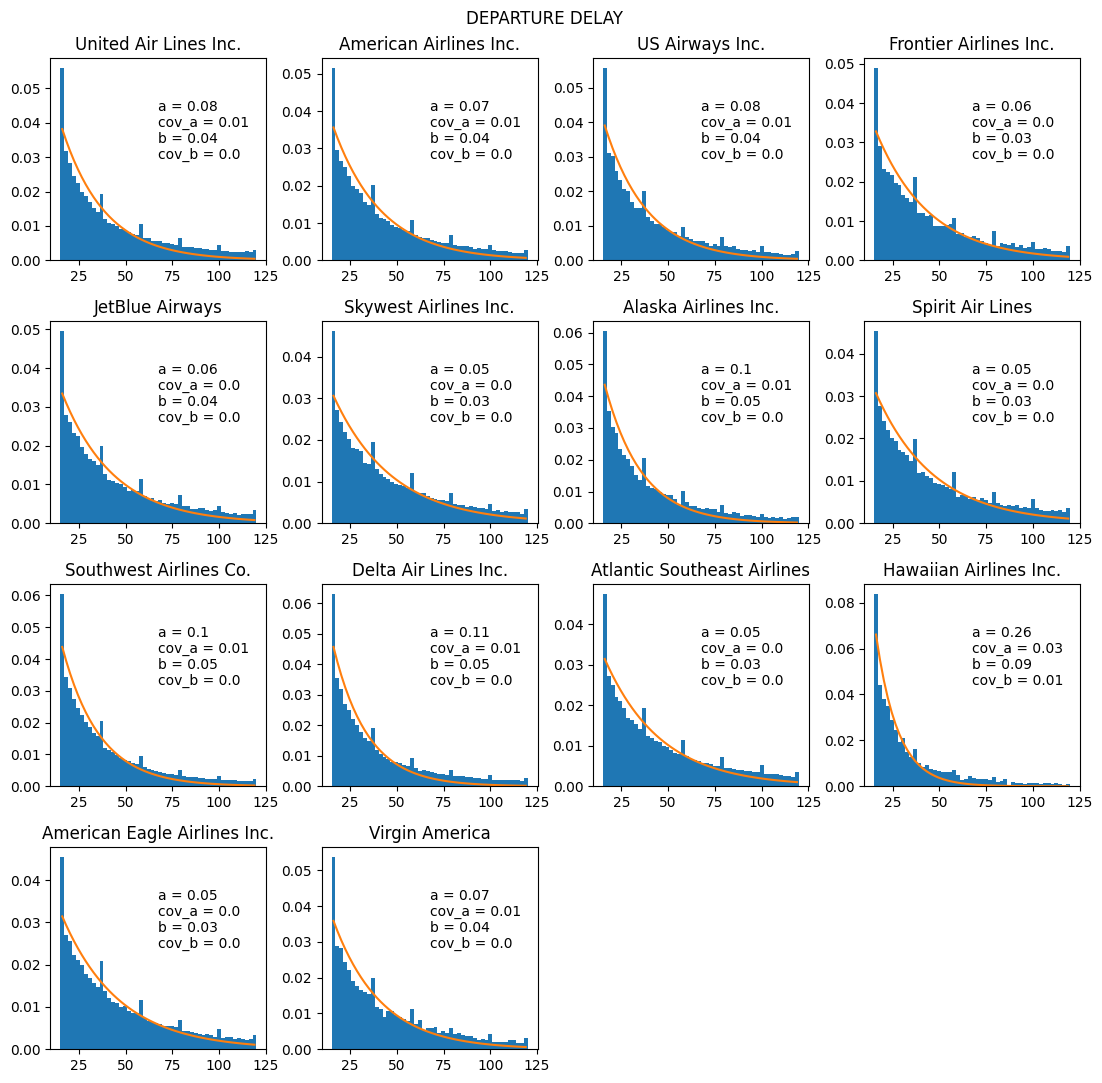

In [12]:
fig = plt.figure(1, figsize=(11,11))
i = 0
for x in df_airlines['IATA_CODE']:
    i += 1
    ax = fig.add_subplot(4,4,i)
    counts, bins, patches = plt.hist(x = df_flights[df_flights['AIRLINE']==x]['DEPARTURE_DELAY'],range = (15,120), density=True, bins=50) # 15 min to 3 hours
    plt.title(dict_airlines[x], fontsize = 12)
    x_bin = 0.5 * (bins[1:] + bins[:-1])

    # fit the exp distribubtion
    popt, pcov = curve_fit(dist_exp, x_bin, counts, p0 = (1, 1e-6))
    perr = np.sqrt(np.diag(pcov))
    plt.plot(x_bin, dist_exp(x_bin, *popt))
    ax.text(0.5, 0.5, 'a = {}\ncov_a = {}\nb = {}\ncov_b = {}'.format(round(popt[0],2), round(perr[0],2), round(popt[1],2), round(perr[1],2)), transform=ax.transAxes)
plt.suptitle("DEPARTURE DELAY")
plt.tight_layout()


To avoid extreme values, we discard those which delays over two hours.

In [13]:
df_flights.drop(df_flights[df_flights["DEPARTURE_DELAY"]>120].index, inplace=True)

In [29]:
def get_delays(df, airline=None):
    if airline is not None:
        df1 = df[df['AIRLINE'] == airline]
        df2 = df1.groupby(['MONTH', 'SCHEDULED_DEPARTURE', 'ORIGIN_AIRPORT'])['DEPARTURE_DELAY'].apply(lambda x: {'MEAN': x.mean()}).unstack().reset_index()
    else:
        df1 = df.copy()
        df2 = df1.groupby(['AIRLINE', 'MONTH', 'SCHEDULED_DEPARTURE', 'ORIGIN_AIRPORT'])['DEPARTURE_DELAY'].apply(lambda x: {'MEAN': x.mean()}).unstack().reset_index()
    return df2


We build the baseline model by linear regression based on the one-hot encoded 'AIRLINE', 'MONTH' and 'ORIGIN_AIRPORT', and the 'SCHEDULED_DEPARTURE' time in minutes. 

In [50]:
df_flights_2 = df_flights.copy()

In [47]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# def label_encoder(df, column):
#     label_encoder = LabelEncoder()
#     column_encoded = label_encoder.fit_transform(df[column])
#     df[column] = column_encoded

# label_encoder(df_flights_2, 'ORIGIN_AIRPORT')
# label_encoder(df_flights_2, 'MONTH')


In [51]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def baseline_model(df_flights):
    df3 = get_delays(df_flights)
    onehot_encoder = OneHotEncoder(sparse_output=False)
    integer_airline_encoded = df3['AIRLINE'].to_frame()
    onehot_airline_encoded = onehot_encoder.fit_transform(integer_airline_encoded)
    integer_airport_encoded = df3['ORIGIN_AIRPORT'].to_frame()
    onehot_airport_encoded = onehot_encoder.fit_transform(integer_airport_encoded)
    integer_month_encoded = df3['MONTH'].to_frame()
    onehot_month_encoded = onehot_encoder.fit_transform(integer_month_encoded)
    departure_min = np.array(df3['SCHEDULED_DEPARTURE'])
    departure_min = departure_min.reshape(len(departure_min),1)
    X = np.hstack((onehot_airline_encoded, onehot_month_encoded, onehot_airport_encoded, departure_min))
    Y = np.array(df3['MEAN'])
    Y = Y.reshape(len(Y), 1)
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3)
    return X_train, X_test, Y_train, Y_test


The MSE and error on the test set is

In [52]:
from sklearn import linear_model

X_train, X_test, Y_train, Y_test = baseline_model(df_flights_2)
model = linear_model.LinearRegression().fit(X_train,Y_train)

def baseline_test(model, X_test, Y_test):
    pred = model.predict(X_test)
    print("MSE =", sklearn.metrics.mean_squared_error(pred, Y_test))
    count = 0
    for i, val in enumerate(Y_test):
        if abs(val-pred[i]) > 15:
            count += 1
    print('Error {:.2f}%'.format(count / len(pred) * 100))


baseline_test(model, X_test, Y_test)

MSE = 159.85899719186764
Error 11.16%


We can easily improve the baseline by separating the airline in different cases. 

In [53]:
def baseline_model_by_airline(df_flights, airline):
    df3 = get_delays(df_flights, airline)
    onehot_encoder = OneHotEncoder(sparse_output=False)
    integer_airport_encoded = df3['ORIGIN_AIRPORT'].to_frame()
    onehot_airport_encoded = onehot_encoder.fit_transform(integer_airport_encoded)
    integer_month_encoded = df3['MONTH'].to_frame()
    onehot_month_encoded = onehot_encoder.fit_transform(integer_month_encoded)
    departure_min = np.array(df3['SCHEDULED_DEPARTURE'])
    departure_min = departure_min.reshape(len(departure_min),1)
    X = np.hstack((onehot_month_encoded, onehot_airport_encoded, departure_min))
    Y = np.array(df3['MEAN'])
    Y = Y.reshape(len(Y), 1)
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3)
    return X_train, X_test, Y_train, Y_test



models = dict()
errs = dict()
for airline in dict_airlines:
    X_train, X_test, Y_train, Y_test = baseline_model_by_airline(df_flights_2, airline)
    model = linear_model.LinearRegression().fit(X_train,Y_train)
    models[airline] = model
    pred = model.predict(X_test)
    count = 0
    for i, val in enumerate(Y_test):
        if abs(val-pred[i]) > 15:
            count += 1
    errs[airline] = count / len(pred)


In [54]:
print(errs)

{'UA': 0.17314026474426697, 'AA': 0.04972761558876938, 'US': 0.0494148244473342, 'F9': 0.20170109356014582, 'B6': 0.12297142857142856, 'OO': 0.14613452793049617, 'AS': 0.02275132275132275, 'NK': 0.14392630972941853, 'WN': 0.08955150562460087, 'DL': 0.0617359413202934, 'EV': 0.12958591207809608, 'HA': 0.007675438596491228, 'MQ': 0.09146503589470885, 'VX': 0.08724100327153762}
